In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from copy import deepcopy

In [2]:
df = pd.read_csv('datasets/ml-latest-small/ratings.csv')
# create dataframe with movieId as rows and userId as columns (using pivot function from ChatGPT)
ratings = df.pivot(index='userId', columns='movieId', values='rating').dropna(thresh=25).dropna(axis='columns', thresh=4)
ratingsMatrix = ratings.values

In [3]:
def findRatings(mat):
    indeces = []
    numRows, numCols = mat.shape
    for row in range(numRows):
        for col in range(numCols):
            if not np.isnan(mat[row][col]):
                indeces.append((row, col))
    return indeces

In [4]:
totalIndeces = findRatings(ratingsMatrix)
train, test = train_test_split(totalIndeces, test_size=0.1)

In [5]:
def rmse(org, rep, indeces):
    sum = 0
    for row, col in indeces:
        diff = org[row][col] - rep[row][col]
        sum += diff * diff
    return np.sqrt(sum/len(indeces))

In [6]:
# returns (P, Q)
def createPQ(dimension, rank):
    return (np.square(np.random.rand(dimension[0], rank)-0.5), np.square(np.random.rand(rank, dimension[1])-0.5))

P, Q = createPQ(ratingsMatrix.shape, 10)

In [7]:
# returns (P, Q, training error, testing error)
def epoch(original, fP, fQ, a, fTrain, fTest):

    # train on elements from training set
    fQ = fQ.T
    for i, j in fTrain:
        alphaGradient = (original[i][j] - np.dot(fP[i], fQ[j]))*a
        fP[i], fQ[j] = fP[i] + fQ[j]*alphaGradient, fQ[j] + fP[i]*alphaGradient
    fQ = fQ.T

    # return P, Q, training error and testing error
    reconstruction = fP @ fQ
    return (fP, fQ, rmse(original, reconstruction, fTrain), rmse(original, reconstruction, fTest))

In [8]:
def matrixCompletion(original, fP, fQ, rank, stepSize, numEpochs):

    # run matrix completion, keep track of error
    trainErrors, testErrors = [], []
    for i in range(numEpochs):
        fP, fQ, trainE, testE = epoch(original, fP, fQ, stepSize, train, test)
        trainErrors.append(trainE)
        testErrors.append(testE)

    # plot error
    plt.plot(range(len(trainErrors)), trainErrors, label='Training Error')
    plt.plot(range(len(testErrors)), testErrors, label='Testing Error')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.show()

    return (fP, fQ)

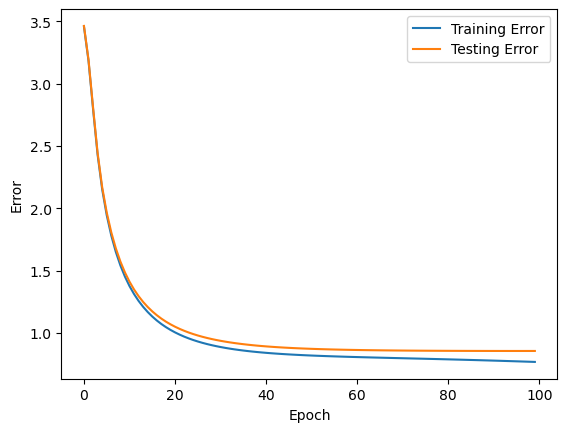

In [9]:
# perform matrix completion
newP, newQ = matrixCompletion(ratingsMatrix, deepcopy(P), deepcopy(Q), 10, 0.001, 100)

In [10]:
# read in movies.csv to map movieIDs to movie names
df = pd.read_csv('datasets/ml-latest-small/movies.csv').set_index('movieId')

In [11]:
# reconstructed matrix
newMatrix = newP @ newQ

# using 'argpartition' to get top n indeces from stack overflow: https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
# get top 20 movies according to new matrix with completed values (UNSORTED)
myRow = newMatrix[newMatrix.shape[0]-1]
top20 = df.loc[ratings.columns[np.argpartition(myRow, -20)[-20:]]]['title']

In [12]:
for title in top20.values:
    print(title)

Sanjuro (Tsubaki Sanjûrô) (1962)
Last Tango in Paris (Ultimo tango a Parigi) (1972)
Sophie Scholl: The Final Days (Sophie Scholl - Die letzten Tage) (2005)
Streetcar Named Desire, A (1951)
Babette's Feast (Babettes gæstebud) (1987)
Black Mirror: White Christmas (2014)
Gallipoli (1981)
Fight Club (1999)
His Girl Friday (1940)
Lifeboat (1944)
Woman in the Dunes (Suna no onna) (1964)
Jules and Jim (Jules et Jim) (1961)
Swept Away (Travolti da un insolito destino nell'azzurro mare d'Agosto) (1975)
Trial, The (Procès, Le) (1962)
Neon Genesis Evangelion: The End of Evangelion (Shin seiki Evangelion Gekijô-ban: Air/Magokoro wo, kimi ni) (1997)
Guess Who's Coming to Dinner (1967)
Discreet Charm of the Bourgeoisie, The (Charme discret de la bourgeoisie, Le) (1972)
Man Bites Dog (C'est arrivé près de chez vous) (1992)
Captain Fantastic (2016)
Three Billboards Outside Ebbing, Missouri (2017)
